In [23]:
from functools import partial
import matplotlib as mpl
import matplotlib.pyplot as plt

import numpy as np

from scipy.optimize import least_squares, minimize

import archimedes as arc
from archimedes import tree
from archimedes.experimental.sysid import make_pem, lm_solve
from archimedes.experimental.discretize import discretize

from cartpole import CartPole

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [24]:
# Dynamics function
system = CartPole()

x0 = np.array([0.0, 3.0, 0.0, 0.0])  # Initial state

t0, tf = 0.0, 10.0

u0 = np.array([0.0])
dt = 0.01
ts = np.arange(t0, tf, dt)


def f(t, x):
    return system.dynamics(t, x, u0)


xs_true = arc.odeint(f, x0=x0, t_span=(t0, tf), t_eval=ts, rtol=1e-6, atol=1e-8)
# xs = np.zeros((len(ts), 4))
# xs[0] = x0
# for i in range(1, len(ts)):
#     xs[i] = f(ts[i-1], xs[i-1], us[i])

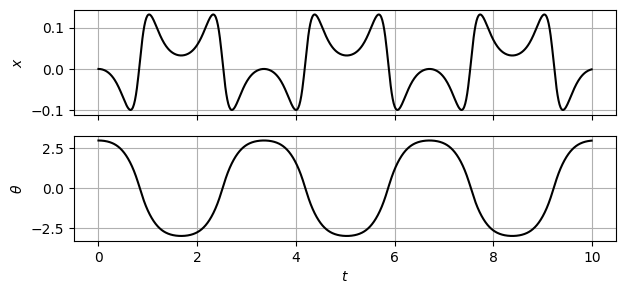

In [25]:
fig, ax = plt.subplots(2, 1, figsize=(7, 3), sharex=True)
ax[0].plot(ts, xs_true[0], c="k")
ax[0].grid()
ax[0].set_ylabel(r"$x$")
ax[1].plot(ts, xs_true[1], c="k")
ax[1].grid()
ax[1].set_ylabel(r"$\theta$")
ax[-1].set_xlabel(r"$t$")

plt.show()

In [26]:
params_guess = {
    "m1": 0.5,
    "m2": 0.5,
    "L": 1.0,
}

# Optimize the initial condition and parameters
# dvs_guess = x0_guess, params_guess
dvs_guess = params_guess
dvs_guess_flat, unravel = tree.ravel(dvs_guess)

In [32]:
@arc.compile(kind="MX", static_argnames=("fwd",))
def residuals(fwd, x0, dvs_guess_flat):
    xs_pred = fwd(x0, dvs_guess_flat)
    return xs_true - xs_pred

# Shooting

In [33]:
def ode_rhs(t, x, params):
    model = system.replace(**params)
    return model.dynamics(t, x, u0)


solver = arc.integrator(ode_rhs, t_eval=ts, rtol=1e-6, atol=1e-8)

@arc.compile
def fwd_shoot(x0, params_flat):
    params = unravel(params_flat)

    # f = arc.compile(ode_rhs)
    xs_pred = solver(x0, params)
    # xs_pred = arc.odeint(
    #     f, x0=x0, t_span=(t0, tf), args=(u0, params), t_eval=ts, rtol=1e-6, atol=1e-8
    # )
    return xs_pred


xs_pred = fwd_shoot(x0, dvs_guess_flat)

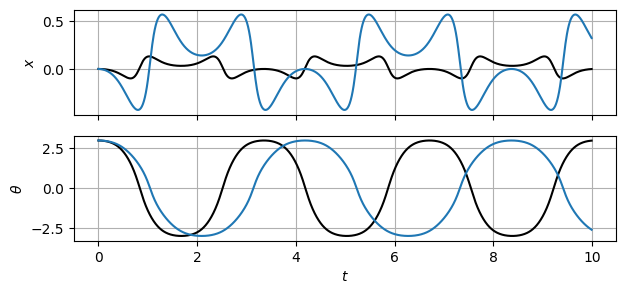

In [34]:
fig, ax = plt.subplots(2, 1, figsize=(7, 3), sharex=True)
ax[0].plot(ts, xs_true[0], c="k")
ax[0].plot(ts, xs_pred[0])
ax[0].grid()
ax[0].set_ylabel(r"$x$")
ax[1].plot(ts, xs_true[1], c="k")
ax[1].plot(ts, xs_pred[1])
ax[1].grid()
ax[1].set_ylabel(r"$\theta$")
ax[-1].set_xlabel(r"$t$")

plt.show()

In [36]:
residuals(fwd_shoot, x0, dvs_guess_flat)

array([[ 0.00000000e+00,  4.67591519e-05,  1.87098670e-04, ...,
        -3.43393480e-01, -3.34166129e-01, -3.25150538e-01],
       [ 0.00000000e+00, -4.31886669e-05, -1.72941856e-04, ...,
         5.55385712e+00,  5.57794146e+00,  5.60098260e+00],
       [ 0.00000000e+00,  9.35265201e-03,  1.87179290e-02, ...,
         9.32924720e-01,  9.12340719e-01,  8.90595644e-01],
       [ 0.00000000e+00, -8.63989180e-03, -1.73197945e-02, ...,
         2.46099900e+00,  2.35607703e+00,  2.25235321e+00]],
      shape=(4, 1000))

In [37]:
@arc.compile
def obj_shoot(dvs_guess_flat):
    r = residuals(fwd_shoot, x0, dvs_guess_flat)
    r_norm = np.sum(r**2, axis=0)
    xs_norm = np.sum(xs_true**2, axis=0)
    return np.sum(r_norm / xs_norm)


obj_shoot(dvs_guess_flat)

array(2656.63441956)

In [38]:
# def callback(intermediate_result):
#     print(intermediate_result.fun, intermediate_result.x)

# bounds = [(0.0, np.inf) for _ in range(len(dvs_guess_flat))]

# minimize(
#     obj_shoot,
#     dvs_guess_flat,
#     # method="L-BFGS-B",
#     method="trust-constr",
#     jac=arc.jac(obj_shoot),
#     hess=arc.hess(obj_shoot),
#     options={"disp": True},
#     bounds=bounds,
#     callback=callback,
# )

In [39]:
# arc.minimize(obj_shoot, dvs_guess_flat)

# Set up PEM

In [40]:
dyn

rk4_ode_rhs(t, x, u, p)

In [53]:
def ode_rhs(t, x, u, params):
    model = system.replace(**params)
    return model.dynamics(t, x, u)

# Discretize with RK4
dyn = discretize(ode_rhs, dt, method="rk4")

def obs(t, x, u, params):
    return x

nx, ny = 4, 4
Q = np.eye(nx)
R = 1e4 * np.eye(ny)
us = np.zeros((1, len(ts)))  # No control input for this example

pem_obj = make_pem(
    dyn,
    obs,
    ts,
    us,
    xs_true,
    x0=x0,
    Q=Q,
    R=R,
)

params_guess = {
    "m1": 0.5,
    "m2": 0.5,
    "L": 1.0,
}

result = lm_solve(
    pem_obj,
    params_guess,
    ftol=1e-4,
    xtol=1e-4,
    gtol=1e-4,
    nprint=1,
)

# print(result.x)

Iteration   Total nfev       Cost       Cost reduction   Step norm    Optimality 
    0           8         1.7463e-01                                   1.65e-02  
    1           10        3.7056e-02       1.38e-01       1.46e-02     1.15e-02  
    2           11        2.5397e-02       1.17e-02       1.25e-02     1.14e-02  
    3           13        1.0284e-02       1.51e-02       8.16e-03     1.14e-02  
    4           15        4.1674e-03       6.12e-03       4.50e-03     3.92e-03  
    5           16        1.6069e-03       2.56e-03       2.88e-03     3.64e-03  
    6           18        9.7111e-04       6.36e-04       1.54e-03     1.35e-03  
    7           19        3.6648e-04       6.05e-04       1.14e-03     1.10e-03  
    8           21        3.0772e-04       5.88e-05       5.36e-04     6.57e-04  
    9           22        1.4873e-04       1.59e-04       5.23e-04     5.56e-04  
    10          24        1.3968e-04       9.05e-06       2.10e-04     3.80e-04  
    11          

In [44]:
# Simulate forward with optimal parameters
dvs_opt_flat = arc.tree.ravel(result.x)[0]
xs_opt = fwd_shoot(x0, dvs_opt_flat)

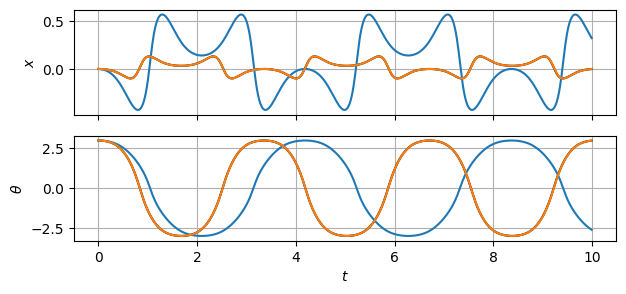

In [45]:
fig, ax = plt.subplots(2, 1, figsize=(7, 3), sharex=True)
ax[0].plot(ts, xs_true[0], c="k")
ax[0].plot(ts, xs_pred[0])
ax[0].plot(ts, xs_opt[0])
ax[0].grid()
ax[0].set_ylabel(r"$x$")
ax[1].plot(ts, xs_true[1], c="k")
ax[1].plot(ts, xs_pred[1])
ax[1].plot(ts, xs_opt[1])
ax[1].grid()
ax[1].set_ylabel(r"$\theta$")
ax[-1].set_xlabel(r"$t$")

plt.show()

## Also estimate initial condition

In [46]:
def ode_rhs(t, x, u, params):
    model = system.replace(**params)
    return model.dynamics(t, x, u)

# Discretize with RK4
dyn = discretize(ode_rhs, dt, method="rk4")

def obs(t, x, u, params):
    return x

nx, ny = 4, 4
Q = np.eye(nx)
R = 1e4 * np.eye(ny)
us = np.zeros((1, len(ts)))  # No control input for this example

pem_obj = make_pem(
    dyn,
    obs,
    ts,
    us,
    xs_true,
    Q=Q,
    R=R,
)

params_guess = {
    "m1": 0.5,
    "m2": 0.5,
    "L": 1.0,
}

x0_guess = np.array([0.0, 3.0, 0.0, 0.0])

result = lm_solve(
    pem_obj,
    (x0_guess, params_guess),
    ftol=1e-4,
    xtol=1e-4,
    gtol=1e-4,
    nprint=1,
)

print(result.x)

Iteration 0, Cost: 1.86375973648801, Grad norm: 0.03457324710068698
Iteration 1, Cost: 0.17432985311171958, Grad norm: 0.016376880507519394
Iteration 2, Cost: 0.037223532208628604, Grad norm: 0.011464885556888476
Iteration 3, Cost: 0.02538721429104309, Grad norm: 0.011242007247102581
Iteration 4, Cost: 0.009978994789714845, Grad norm: 0.011266396142462547
Iteration 5, Cost: 0.004264161990044155, Grad norm: 0.0038501906106625694
Iteration 6, Cost: 0.0015968775981427994, Grad norm: 0.004399195435944763
Iteration 7, Cost: 0.0010621101153692534, Grad norm: 0.0027253379509585614
Iteration 8, Cost: 0.0004238675871528088, Grad norm: 0.003455887171896187
Iteration 9, Cost: 0.00038696376171889086, Grad norm: 0.0029055723210090075
Iteration 10, Cost: 0.0002155381143552224, Grad norm: 0.0031031456256718245
(array([ 0.00361194,  2.99741335,  0.00442155, -0.0033853 ]), {'L': array(0.5024576), 'm1': array(0.7117357), 'm2': array(0.21686146)})


In [47]:
result.nfev

24

In [49]:
# Simulate forward with optimal parameters
x0_opt, params_opt = result.x
params_opt_flat = arc.tree.ravel(params_opt)[0]

xs_opt = fwd_shoot(x0, params_opt_flat)

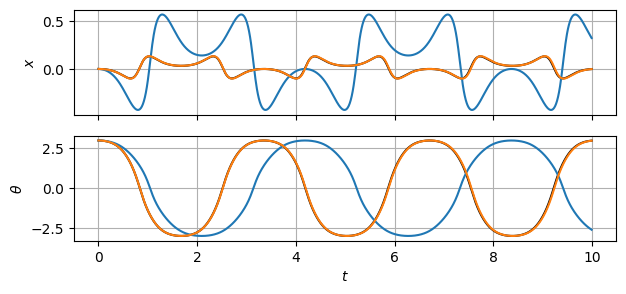

In [50]:
fig, ax = plt.subplots(2, 1, figsize=(7, 3), sharex=True)
ax[0].plot(ts, xs_true[0], c="k")
ax[0].plot(ts, xs_pred[0])
ax[0].plot(ts, xs_opt[0])
ax[0].grid()
ax[0].set_ylabel(r"$x$")
ax[1].plot(ts, xs_true[1], c="k")
ax[1].plot(ts, xs_pred[1])
ax[1].plot(ts, xs_opt[1])
ax[1].grid()
ax[1].set_ylabel(r"$\theta$")
ax[-1].set_xlabel(r"$t$")

plt.show()